# MADGICX's standard adset performance evalution

__Diagram of the ad set__ [win lose evaluation flow](https://app.diagrams.net/#G1GMSCJ_EQPm-NUYhxQVNe7bFD-vVQk46P#%7B%22pageId%22%3A%22VbIS5GhQtAIJzmuHBgNp%22%7D) 

### Check statistical significance

### Method
To check statistical significance of indicator volumnes performing over a 7-day period:
* impressions: number ad view adset
* clicks : number of ad clicks
* conversions: number of subsequent click post ad click
* CTR : Click Through Rate = number of clicks / number of impressions
* Use ARIMA or other time series forecasting methods to predict what "should have" happened
Compare actual results to these predictions (Time Series Models)

We need to perform hypothesis testing. Here's how to approach this:
1. Define your hypothesis: Typically, you'd want to determine if your observed metrics differ significantly from either a baseline period or a control group.
1. Choose the appropriate test:
   1. For comparing metrics between two periods or groups: t-test, z-test, or Mann-Whitney U test
   1. For comparing conversion rates: Chi-square test or Fisher's exact test
   1. For time-series data: Interrupted time series analysis
1. Calculate the test statistic and p-value:

### Desired outputs
* plot time series of daily mean of performance metric indicators
* plot time series of daily adsets below and above performance metric average
* setup to run plots for any objectives

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [16]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
# import tensorflow_probability as tfp
# import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.ml.timeseries import rollingstats as roll
from mining.modules.budget.optimization import rwAdsDataFile as file
from mining.modules.budget.evaluation import adSetMovement as move
from rezaware.modules.lib.spark import execSession

''' restart initiate classes '''
if debug:
    import importlib
    move = importlib.reload(move)
    roll = importlib.reload(roll)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "trend analysis of adset data"

clsFile = file.dataWorkLoads(
    desc = __desc__,
    f_store_mode='local-fs',
    f_store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
clsMove = move.evalWorkLoads(desc=__desc__)
clsStats = roll.mlWorkLoads(desc=__desc__)
clsSpark = execSession.Spawn(desc=__desc__)
print("\n%s class initialization and load complete!" % __desc__)

All functional ADSETMOVEMENT-libraries in EVALUATION-package of BUDGET-module imported successfully!
All packages in rezaware ml timeseries RollingStats imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
__propAttr__ Class initialization complete
__propAttr__ Class initialization complete
sparkFile Class initialization complete
rwAdsData Class initialization complete
__propAttr__ Class initialization complete
adSetMovement Class initialization complete
execSession Class initialization complete
__propAttr__ Class initialization complete
execSession Class initialization complete

trend analysis of adset data class initialization and load complete!


## Load data
Load from file

In [3]:
_fpath = "mining/data/budget/"
_fname = "FullDataset.csv"

__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'

kwargs = {
    "REALMFILTATTR" : 'objective',
    "REALMFILTLIST" : [__def_obj__],
    "UNIXTIMESTAMP" : __def_date_attr__,
}
sdf = clsFile.read_realm(
    realm = __def_realm__,
    to_date = None,
    from_date=None,
    fname = _fname,
    fpath = _fpath,
    **kwargs,
)
# print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()/n"
numeric_cols = [c for c, t in sdf.dtypes if t.startswith('string')==False and t.startswith('bool')==False ]
", ".join(numeric_cols)
sdf = sdf.fillna(0,subset=numeric_cols)
print("Replaced NaN with 0 in %d columns" % len(numeric_cols))

25/03/14 15:41:13 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/03/14 15:41:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/14 15:41:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/14 15:42:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

Loaded FullDataset.csv 58280 rows
Replaced NaN with 0 in 38 columns


## Filter by objective and goal

In [17]:
__def_obj_col__ = 'objective'
__def_opt_goal__= 'checkout'  # 'purchase' action group
__def_dt_cols__ = [f"unix_{__def_date_attr__}", __def_date_attr__]
__def_ids_cols__ = ['adset_id']
__def_ad_met_cols__ = ['spend','impressions', 'clicks', 'reach'] 
__def_ad_ratio_cols__ = ['frequency', 'CTR', 'CPP', 'CPC', 'CPM']
__def_roas_cols__ = ['purchase_value', 'purchase_roas']

_goal_act_cols = [x for x in sdf.columns
                  if x.find(__def_opt_goal__)==0
                  and x not in [*__def_ids_cols__, *__def_ad_met_cols__, 
                                *__def_dt_cols__, *__def_roas_cols__]]

''' Remove goal action cols not greater than zero '''
count_dict= {}
for act  in _goal_act_cols:
    count_dict[act]=sdf.select(act).dropna().count()

_conv_met_cols_lst = [k for k,v in count_dict.items() if v>0]
print("Conversion metric column list: %s" % ", ".join(_conv_met_cols_lst))

[Stage 506:=============================================>           (4 + 1) / 5]

Conversion metric column list: checkout_offsite_conversion__fb_pixel_add_to_cart, checkout_offsite_conversion__fb_pixel_initiate_checkout, checkout_offsite_conversion__fb_pixel_add_payment_info


## Group by adset id and date

In [18]:
_grp_by_id_sdf = sdf.groupBy(F.col(__def_date_attr__))\
                .agg(*[F.mean(c).alias(f"{c}") for c in __def_ad_met_cols__],
                     *[F.mean(c).alias(f"{c}") for c in _conv_met_cols_lst])\
                .orderBy(__def_date_attr__)
print("Grouped data % rows of %d original rows" % (_grp_by_id_sdf.count(), sdf.count()))

# Change conversion column names 
conv_col_lst = [c for c in _grp_by_id_sdf.columns if c.find(__def_opt_goal__)==0]
new_cols_lst = [c.replace('__',' ').replace('_',' ') for c in conv_col_lst]
new_cols_lst = ["_".join(c.split()[-3:]) for c in new_cols_lst]

for _old_col, _new_col in zip(conv_col_lst, new_cols_lst):
    print(f"Convert {_old_col} --> {_new_col}") 
    _grp_by_id_sdf=_grp_by_id_sdf.withColumnRenamed(_old_col, _new_col)

print("Converted %d columns" % len(new_cols_lst))

[Stage 515:=============================================>           (4 + 1) / 5]

Grouped data 28ows of 58280 original rows
Convert checkout_offsite_conversion__fb_pixel_add_to_cart --> add_to_cart
Convert checkout_offsite_conversion__fb_pixel_initiate_checkout --> pixel_initiate_checkout
Convert checkout_offsite_conversion__fb_pixel_add_payment_info --> add_payment_info
Converted 3 columns


## Compute the 7-day moving average of adset

### Significance test method
#### Monotonic Trend Detection
The ```monotonic_trend()``` function examines whether your metrics are consistently increasing by:
1. Testing for strictly increasing trends (each value higher than the previous)
1. Testing for non-strict increasing trends (allowing equal values)
1. Calculating Spearman rank correlation to measure trend strength
1. Providing p-values to determine statistical significance of the trend

#### Baseline Generation Methods
The ```generate_baseline()``` function offers three approaches for generating baselines from historic data:
1. __Moving Average__: Uses a rolling window (default 28 days) of previous data
1. __Same Period Last Year__: Compares to the same dates from the previous year
1. __Seasonal Average__: Accounts for day-of-week effects by averaging similar days

#### Statistical Significance Testing
Using the ```test_significance()```For different metric types, appropriate tests are applied:
1. __T-tests__ for daily comparisons of count metrics (impressions, clicks, reach)
1. __Chi-square tests__ for conversion rates (CTR)
1. Fisher's Exact Test for small sample sizes (more appropriate for low-volume campaigns)
1. Confidence Intervals to determine the range of possible true values

#### Process
You can easily adapt this framework to your specific needs by:
* Loading and enhancing your actual ad metrics data
* Specifying your test period (default: last 7 days)
* Choosing an appropriate baseline method
* Running the analysis
* Interpreting the comprehensive results

In [19]:
kwargs = {
    "DATEATTR" : 'updated_time',
    "ADMETRICLIST" : __def_ad_met_cols__, #['impressions', 'clicks', 'reach'],
    "CONVMETRICLIST": new_cols_lst,
}

analysis_results = clsMove.analyze_momentum(
    data = _grp_by_id_sdf,
    recent_days = 7,
    baseline_method ='moving_average',
    baseline_window =14,
    **kwargs,
    )

print("analysis returned results dict with keys:\n%s" 
      % "\n".join([x.upper() for x in analysis_results.keys()]))

analysis returned results dict with keys:
STATISTICAL_TESTS
TEST_DATA
BASELINE_DATA
TREND_PLOTS


## Print results

In [20]:
# Print diagnostic information
print("\n=== CTR Analysis Diagnostic Information ===\n")
if 'ctr_diagnostic' in analysis_results['statistical_tests']:
    diagnostic = analysis_results['statistical_tests']['ctr_diagnostic']
    print(f"Test CTR calculated: {diagnostic['test_ctr_calculated']}")
    print(f"Test has zero impressions: {diagnostic['test_has_zero_impressions']}")
    print(f"Test CTR has NaN values: {diagnostic['test_ctr_has_nan']}")
    print(f"Test CTR values: {diagnostic['test_ctr_values']}")
    print(f"Baseline CTR calculated: {diagnostic['baseline_ctr_calculated']}")
    print(f"Baseline has zero impressions: {diagnostic['baseline_has_zero_impressions']}")
    print(f"Baseline CTR has NaN values: {diagnostic['baseline_ctr_has_nan']}")
    print(f"Baseline CTR values: {diagnostic['baseline_ctr_values']}")

# Print key trend results for CTR if available
if 'ctr_trend' in analysis_results['statistical_tests']:
    print("\n=== CTR Trend Analysis ===\n")
    trend_info = analysis_results['statistical_tests']['ctr_trend']
    print(trend_info)

# Print t-test results for CTR if available
if 'ctr_daily_ttest' in analysis_results['statistical_tests']:
    print("\n=== CTR T-Test Results ===\n")
    test_info = analysis_results['statistical_tests']['ctr_daily_ttest']
    print(test_info)


=== CTR Analysis Diagnostic Information ===

Test CTR calculated: True
Test has zero impressions: False
Test CTR has NaN values: True
Test CTR values: [0.014217529077742395, 0.042310549473873256, 0.03171939492423729, 0.03614947380777166, 0.028920053878456538, 0.03082775065288975, 0.03241650294695481]
Baseline CTR calculated: True
Baseline has zero impressions: False
Baseline CTR has NaN values: False
Baseline CTR values: [0.02174183865785657, 0.012132396393431583, 0.012908110682765997, 0.01465590972629093, 0.015365523532204921, 0.015172502385401139, 0.018810282106298575, 0.019011384000995887, 0.02250531866800351, 0.024216772211058998, 0.024989165029675443, 0.02308187354357839, 0.023448903172466135, 0.019962991665764117]

=== CTR Trend Analysis ===

{'strictly_increasing': False, 'non_strict_increasing': False, 'trend_strength': 0.07142857142857144, 'trend_p_value': 0.8790481931481541, 'significant_trend': False, 'valid_data_points': 7}

=== CTR T-Test Results ===

{'t_statistic': 4.21

In [21]:
print("\n=== Ad Performance Analysis ===\n")
print("Monotonic Trend Analysis:")
for metric in ['impressions', 'clicks', 'reach']:
    trend_info = analysis_results['statistical_tests'][f'{metric}_trend']
    print(f"\n{metric.capitalize()}:")
    print(f"  Strictly increasing: {trend_info['strictly_increasing']}")
    print(f"  Non-strict increasing: {trend_info['non_strict_increasing']}")
    print(f"  Trend strength (Spearman): {trend_info['trend_strength']:.3f}")
    print(f"  Statistically significant trend: {trend_info['significant_trend']}")

print("\nStatistical Significance vs Baseline:")
for metric in ['impressions', 'clicks', 'reach']:
    test_info = analysis_results['statistical_tests'][f'{metric}_daily_ttest']
    print(f"\n{metric.capitalize()}:")
    print(f"  t-statistic: {test_info['t_statistic']:.3f}")
    print(f"  p-value: {test_info['p_value']:.3f}")
    print(f"  Statistically significant: {test_info['significant']}")

# If CTR was calculated, show those results too
if 'clicks_rate_tests' in analysis_results['statistical_tests']:
    rate_info = analysis_results['statistical_tests']['clicks_rate_tests']
    print("\nClick-Through Rate (CTR) Analysis:")
    print(f"  Chi-square p-value: {rate_info['chi2_p_value']:.3f}")
    print(f"  Chi-square significant: {rate_info['chi2_significant']}")
    print(f"  Fisher's Exact p-value: {rate_info['fisher_p_value']:.3f}")
    print(f"  Fisher's Exact significant: {rate_info['fisher_significant']}")


=== Ad Performance Analysis ===

Monotonic Trend Analysis:

Impressions:
  Strictly increasing: False
  Non-strict increasing: False
  Trend strength (Spearman): -0.893
  Statistically significant trend: True

Clicks:
  Strictly increasing: False
  Non-strict increasing: False
  Trend strength (Spearman): -0.929
  Statistically significant trend: True

Reach:
  Strictly increasing: False
  Non-strict increasing: False
  Trend strength (Spearman): -0.893
  Statistically significant trend: True

Statistical Significance vs Baseline:

Impressions:
  t-statistic: -2.120
  p-value: 0.047
  Statistically significant: True

Clicks:
  t-statistic: -1.632
  p-value: 0.119
  Statistically significant: False

Reach:
  t-statistic: -1.872
  p-value: 0.077
  Statistically significant: False


## Visualize Trends

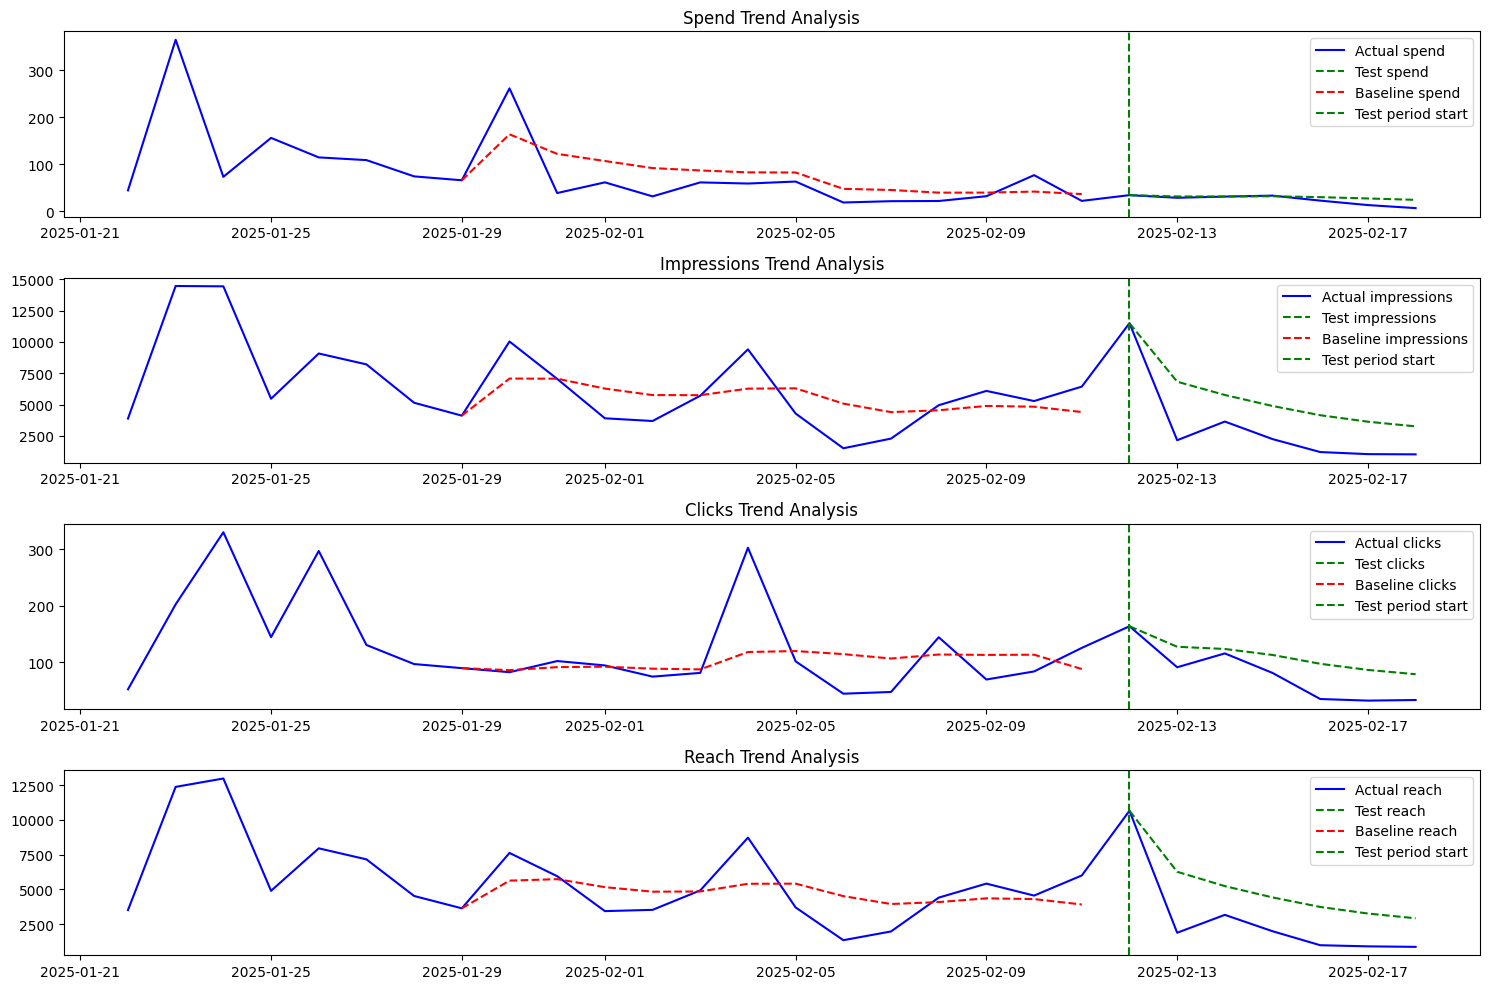

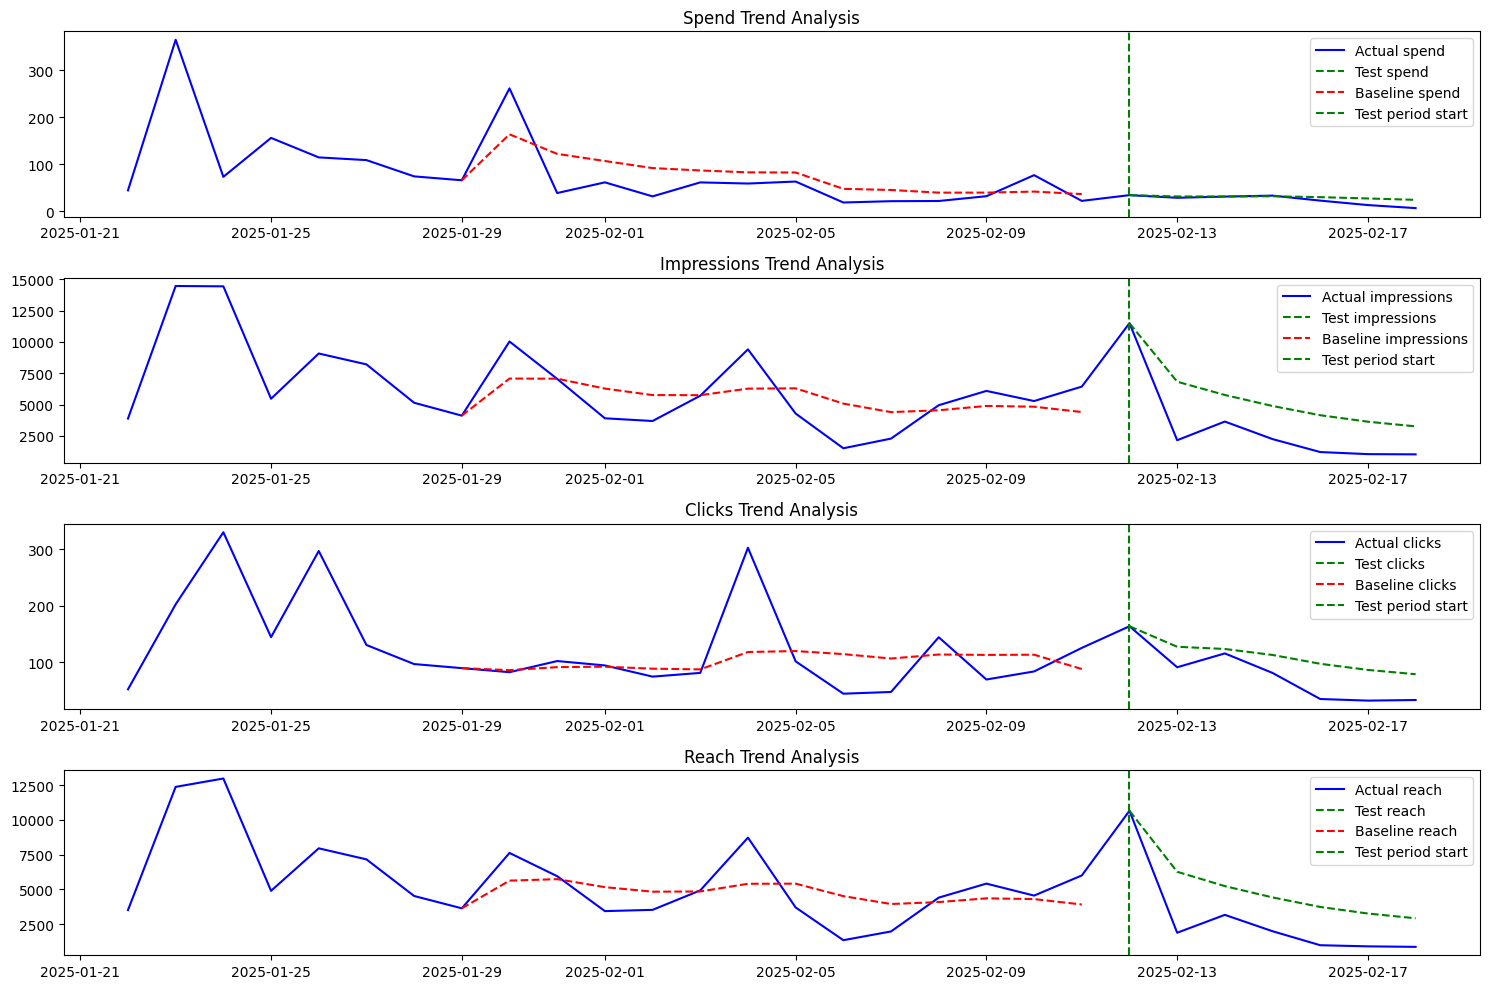

In [22]:
from IPython.display import display
%matplotlib inline
# Run to plot the trends
display(analysis_results['trend_plots'])
plt.figure(analysis_results['trend_plots'].number)  # Make the figure active
plt.show()  # Display it"